
# Build a basic ME model

We will try to build an ME model from the NC_000913.2 Genbank file, the iJO1366 M model, and the complex reconstruction from iJL1650-ME

In [1]:
# python imports
import re
import json
from os.path import join
import cPickle
import statistics
import numpy as np
import math
import itertools

# third party imports\
import pandas
import escher
import cobra.test
import cloudpickle

# ecoli me
import ecolime
from ecolime.flat_files import *
from ecolime.ecoli_k12 import *
from ecolime import (ribosome, tRNA_charging, transcription, translocation, 
                     chaperones, DNA_replication, translation)
from ecolime.characterization.biomass_allocation import get_membrane_composition, get_membrane_protein

from minime.util import dogma
from minime import *
from minime.util import building
from minime.util.mass import compute_RNA_mass
from minime.solve.algorithms import binary_search, fva, solve_at_growth_rate
from minime.solve.symbolic import compile_expressions

# Colton TODOs 
- [x] 1) look into all of the free modifications in the original ME and make sure none of thes reactions are blocked
- [x] 2) Frameshifts (b2891)
- [x] 3) selenocysteine
- [x] 4) Non AUG start codons (15%)
- [x] 5) moaD is a modifier protein that never has to be made
- [x] 6) Correct rpL7/12_mod_1:acetyl modification
    - in iOL as a free modification. could be corrected
- 7) Remaining Genes: 
     - pflC, citC, norW - formed but not used in iJL1678
     - FusA, tsf - translation reactions need audited and improved
     - [x] paaD - FeS transfer chaperone. This process needs audited and improved
     - [x] pnp, orn, rhlB - degradosome
     - [x] secB, tatE - Translocation Pathways
     - [x] lgt, lspA - part of translocation. Not sure how to incorporate-ask Joanne about this
- [x] 8) apply ndh1,ndh2 1:1 flux split

# Create Model Object and populate its global info
This includes important parameters that are used to calculate coupling constraints
as well as organism-specific information such as peptide processing types

In [2]:
# Define Models
ijo = cobra.io.load_json_model('iJO1366.json')
me = MEmodel('iJO1366-ME')

# "Translational capacity" of organism
me.global_info['kt'] =  4.5 #(in h-1)scott 2010, RNA-to-protein curve fit
me.global_info['r0'] =  0.087 #scott 2010, RNA-to-protein curve fit
me.global_info['k_deg'] =  1.0/5. * 60.0  # 1/5 1/min 60 min/h # h-1

# Molecular mass of RNA component of ribosome
me.global_info['m_rr'] = 1700. # in kDa

# Average molecular mass of an amino acid
me.global_info['m_aa'] = 109. / 1000. #109. / 1000. # in kDa

# Proportion of RNA that is rRNA
me.global_info['f_rRNA'] = .86
me.global_info['m_nt'] = 324. / 1000. # in kDa
me.global_info['f_mRNA'] = .02

# tRNA associated global information
me.global_info['m_tRNA'] = 25000. / 1000. # in kDA
me.global_info['f_tRNA'] = .12

me.global_info['RNA_polymerase'] = {'CPLX0-221', 'RNAPE-CPLX', 'CPLX0-222', 'RNAP32-CPLX',
                                    'RNAP54-CPLX', 'RNAP70-CPLX', 'RNAPS-CPLX'}

me.global_info['c_ribo'] = me.global_info['m_rr'] / me.global_info['f_rRNA'] / me.global_info['m_aa']
me.global_info['k_RNAP'] = mu * me.global_info['c_ribo']

# Translation associated global information
me.global_info["translation_terminators"] = translation.translation_stop_dict
me.global_info["met_start_codons"] = {"AUG", "GUG", "UUG", "AUU", "CUG"}
me.global_info["peptide_processing_subreactions"] = {"peptide_deformylase_processing": 1,
                                                     "peptide_chain_release": 1,
                                                     "ribosome_recycler": 1}
me.global_info["translation_elongation_subreactions"] = ['FusA_mono_elongation', 'Tuf_gtp_regeneration']
me.global_info['translation_start_subreactions'] = ['fmet_addition_at_START']

# Membrane Surface Area Constraint Information
me.global_info['membrane_thickness'] = {'Inner_Membrane': 3.75, 'Outer_Membrane': 13.0} # in nm (other IM_thick = 4.5)

# This may be unnecessary 
# Transcription associated global information
me.global_info["transcription_initiation_length"] = 16  # nucleotides

me.global_info['translocation_multipliers'] = defaultdict(dict)
for enzyme, value in translocation.multipliers.items():
    me.global_info['translocation_multipliers'][enzyme] = value

# Folding Properties
me.global_info['temperature'] = 37
me.global_info['propensity_scaling'] = .45

# DNA Replication Parameters
me.global_info['GC_fraction'] = 0.507896997096

## Begin by loading metabolites and build Metabolic reactions

In [3]:
m_model = ecolime.get_m_model()
# some of the "metabolites" in iJO1366 "M" model are actually complexes. We pass those in
# so they get created as complexes, not metabolites.
complex_list = []
complex_list.extend(i.id for i in m_model.metabolites if i.id.startswith("CPLX"))
complex_list.extend(i.id for i in m_model.metabolites if i.id.startswith("EG"))
complex_list.extend(i.id for i in m_model.metabolites if "-MONOMER" in i.id)
complex_list.extend(i.id for i in m_model.metabolites if "-CPLX" in i.id)
complex_list.extend(i.id for i in m_model.metabolites if "_mod_" in i.id)
# temp fix
complex_list.extend(i.id for i in m_model.metabolites if i.id.startswith("Isc"))
complex_list.extend(i.id for i in m_model.metabolites if i.id.startswith("Suf"))
complex_list = set(complex_list)
building.add_m_model_content(me, m_model, complex_metabolite_ids=complex_list)

# If lower_bound open, model feeds G6P into EDD
me.reactions.EX_pqq_e.lower_bound = 0
me.reactions.EX_pqq_e.upper_bound = 0

Assigned tl to c
Assigned hemed to c
Assigned pqq to c
Assigned dpm to c
Assigned 23bpg to c
Assigned tqn to c


In [4]:
for met in me.global_info['RNA_polymerase']:
    RNAP_obj = RNAP(met)
    me.add_metabolites(RNAP_obj)

In [5]:
# Used for mass balance checks
df = pandas.read_table('../ecolime/modification.txt', names=['mod', 'formula','na'])
df = df.drop('na', axis=1).set_index('mod').dropna(how='any')
me.global_info['modification_formulas'] = df.T.to_dict()

In [6]:
essential_list = [
    'LI_c',
    'cs_e',
    'tl_c', # added in old ME but not metioned in supplement tables
    'Oxidized_c',
    'palmitate_c', # TODO FIX. this should not be required
    'cu_c', # needed for NDH activity. TODO fix this
    'C10H8O5_c', 'C9H9O4_c', # for tRNA modifications
    'NiFeCoCN2_c', #'acetyl_c',
    'RNase_m5','RNase_m16','RNase_m23'] # RNAses are gaps in model, fix how cs is added to

for met_id in essential_list:
    r = cobra.Reaction("EX_" + met_id)
    me.add_reaction(r)
    r.reaction = met_id + " <=> "

unknown metabolite 'LI_c' created
unknown metabolite 'Oxidized_c' created
unknown metabolite 'palmitate_c' created
unknown metabolite 'C10H8O5_c' created
unknown metabolite 'C9H9O4_c' created
unknown metabolite 'NiFeCoCN2_c' created
unknown metabolite 'RNase_m5' created
unknown metabolite 'RNase_m16' created
unknown metabolite 'RNase_m23' created


In [7]:
# add oxidative damage reaction to form 3fe4s 
# TODO this can be done better
fes_damage = cobra.Reaction('4fe4s_oxidation')
me.add_reaction(fes_damage)
fes_damage.reaction = '4fe4s_c -> fe2_c + 3fe4s_c'

unknown metabolite '3fe4s_c' created


### Add tRNA mods (iOL uses keffs of 65. for all modifications)

In [8]:
for mod, components in get_tRNA_modification_procedures().items():
    tRNA_mod = ModificationData(mod, me)
    tRNA_mod.enzyme = components['machines']
    tRNA_mod.stoichiometry = components['metabolites']
    tRNA_mod.keff = 65. # iOL uses 65 for all tRNA mods
    if 'carriers' in components.keys():
        for carrier, stoich in components['carriers'].items():
            if stoich < 0:
                tRNA_mod.enzyme += [carrier]
            tRNA_mod.stoichiometry[carrier] = stoich

## DNA replication (comment out for now and add in later)

In [9]:
dna_demand_stoich = DNA_replication.return_gr_dependent_dna_demand(me.global_info['GC_fraction'])

data = ComplexData('DNA_polymerase', me)
stoichiometry = DNA_replication.DNA_polymerase_stoichiometry
data.stoichiometry = {"protein_" + bnum: value for bnum, value in stoichiometry.items()}
data.create_complex_formation(verbose=False)

DNA_replication = SummaryVariable("DNA_replication")
me.add_reaction(DNA_replication)
DNA_replication.add_metabolites(dna_demand_stoich)
DNA_biomass = Constraint("DNA_biomass")
DNA_biomass.elements = {e: abs(v) for e, v in DNA_replication.check_mass_balance().items()}
DNA_replication.add_metabolites({DNA_biomass: 1})

# Comment out DNA_polymerase for now

#DNA_replication.add_metabolites({'DNA_polymerase': -1e-4})
me._DNA_biomass_dilution.lower_bound = mu
me._DNA_biomass_dilution.upper_bound = mu

## Add transcription and  translation related subreactions

In [10]:
# add the translation subreactiondata objects to model
translation.add_translation_subreactions_to_model(me)

In [11]:
#for subreaction in translation.translation_subreactions:
#    subreaction_data = SubreactionData(subreaction, me)
#    enzymes = ribosome.translation_subreactions[subreaction]['enzyme']
#    subreaction_data.enzyme = enzymes
    

for subreaction in transcription.transcription_subreactions:
    subreaction_data = SubreactionData(subreaction, me)
    enzymes = transcription.transcription_subreactions[subreaction]['enzymes']
    subreaction_data.stoichiometry = transcription.transcription_subreactions[subreaction]['stoich']
    subreaction_data.enzyme = enzymes

In [12]:
data = ComplexData('RNA_degradosome', me)
for subunit, value in ecoli_k12.RNA_degradosome.items():
    data.stoichiometry[subunit] = value
data.create_complex_formation(verbose=False)

data = ModificationData('RNA_degradation_machine', me)
data.enzyme = 'RNA_degradosome'

data = ModificationData('RNA_degradation_atp_requirement', me)
# .25 water equivaltent for atp hydrolysis and 1 h20 equivalent for to 
# restore OH group in nucleotide monophosphate during RNA hydrolysis
data.stoichiometry = {'atp_c': -.25, 'h2o_c': -1.25, 'adp_c': .25,
                      'pi_c': .25, 'h_c': 1.25}

In [13]:
for subreaction in me.subreaction_data:
    if type(subreaction.enzyme) == list:
        for enzyme in subreaction.enzyme:
            enzyme_met = Complex(enzyme)
            me.add_metabolites([enzyme_met])
    elif type(subreaction.enzyme) == str:
        enzyme_met = Complex(subreaction.enzyme)
        me.add_metabolites([enzyme_met])

## Add transcription and translation reactions

In [14]:
gb_filename = join(ecoli_files_dir,'NC_000913.2.gb')                                                                                    
TU_df = pandas.read_csv(join(ecoli_files_dir,'TUs_from_ecocyc.txt'), delimiter="\t", index_col=0)

building.build_reactions_from_genbank(me, gb_filename, TU_df, tRNA_modifications=get_tRNA_modification_targets(),
                                      verbose=False,
                                      translation_terminators=translation.translation_stop_dict,
                                      frameshift_dict=translation.frameshift_dict,
                                     methionine_cleaved=translation.methionine_cleaved,
                                     folding_dict=translation.folding_dict,
                                     tRNA_to_codon=translation.tRNA_to_codon)

Adding selenocystein for b1474
Applying frameshift on b2891
Adding selenocystein for b3894
Adding selenocystein for b4079

/home/sbrg-cjlloyd/minime/minime/core/MEReactions.py:562 UserWarning: RNA Polymerase () not found
/home/sbrg-cjlloyd/minime/minime/core/MEReactions.py:697 UserWarning: ribosome not found


In [15]:
sigma_to_RNAP_dict = transcription.sigma_factor_complex_to_rna_polymerase_dict
# Moved from buidling to make that function organism unspecific
for TU_id in TU_df.index:
    transcription_data = me.transcription_data.get_by_id(TU_id)
    rho_dependent = TU_df.rho_dependent[TU_id]
    sigma = TU_df.sigma[TU_id]
    RNA_polymerase = sigma_to_RNAP_dict[sigma]
    transcription_data.RNA_polymerase = RNA_polymerase
    transcription_data.rho_dependent = rho_dependent

In [16]:
# Changed verbose=False to squash complex creation output
ribosome.add_ribosome(me, verbose=False)
transcription.add_RNA_polymerase_complexes(me, verbose=False)

## Associate the tRNA synthetases

The tRNA charging reactions were automatically added when loading the genome from the genbank file. However, the charging reactions still need to be made aware of the tRNA synthetases which are responsible.

In [17]:
with open(join(ecoli_files_dir, "amino_acid_tRNA_synthetase.json"), "rb") as infile:
    aa_synthetase_dict = json.load(infile)
for data in me.tRNA_data:
    data.synthetase = str(aa_synthetase_dict[data.amino_acid])

## Add in complex Formation with modifications

In [18]:
# ME_complex_dict is a dict of {'complex_id': [{'bnum' : count}]}
rna_components = {"b3123"} # component id should have RNA_ instead of protein_
complex_stoichiometry_dict, complex_modification_dict = get_complex_composition(rna_components)
building.add_model_complexes(me, complex_stoichiometry_dict, complex_modification_dict)

In [19]:
# two different reactions can add a lipoate modification.
# We create a separate ModificationData for each one
lipo = me.modification_data.get_by_id("mod_lipo_c")
alt_lipo = ModificationData("mod_lipo_c_alt", me)
#alt_lipo.stoichiometry = lipo.stoichiometry

lipo.stoichiometry = {"lipoamp_c": -1, "amp_c": 1}
lipo.enzyme = 'EG11796-MONOMER'
lipo.keff = 65.

alt_lipo.stoichiometry = {'EG50003-MONOMER_mod_pan4p_mod_lipo':-1,
                          'EG50003-MONOMER_mod_pan4p':1,
                          'h_c':-1,}
alt_lipo.enzyme = 'EG11591-MONOMER'
alt_lipo.keff = 65.

for cplx_data in lipo.get_complex_data():
    alt_cplx_data = ComplexData(cplx_data.id + "alt", me)
    alt_cplx_data.complex_id = cplx_data.complex_id
    alt_cplx_data.stoichiometry = cplx_data.stoichiometry
    alt_cplx_data.chaperones = cplx_data.chaperones
    alt_cplx_data.modifications = cplx_data.modifications.copy()
    alt_cplx_data.modifications[alt_lipo.id] = \
        alt_cplx_data.modifications.pop(lipo.id)

In [20]:
# chaperones          
bmocogdp_chaperones = {'TMAOREDUCTI-CPLX':'EG12195-MONOMER', #bmocogdp
                 'DIMESULFREDUCT-CPLX':'G6849-MONOMER', #bmocogdp
                 'NITRATREDUCTA-CPLX':'NARJ-MONOMER', #bmocogdp
                 'NITRATREDUCTZ-CPLX':'NARW-MONOMER', #bmocogdp
                 'NAP-CPLX':'NAPD-MONOMER', #bmocogdp
                 'NAPAB-CPLX_NAPC-MONOMER':'NAPD-MONOMER'} #bmocogdp
for chaperone in set(bmocogdp_chaperones.values()):
    new_mod = ModificationData('mod_bmocogdp_c_' + chaperone, me)
    new_mod.enzyme = chaperone
    new_mod.stoichiometry = {'bmocogdp_c': -1}

for cplx_data in me.modification_data.get_by_id('mod_bmocogdp_c').get_complex_data():
    cplx_id = cplx_data.id.split('_mod')[0]
    if cplx_id in bmocogdp_chaperones:
        cplx_data.modifications['mod_bmocogdp_c_' + bmocogdp_chaperones[cplx_id]] = \
            cplx_data.modifications.pop('mod_bmocogdp_c')

 - Read "The CO and CN− ligands to the active site Fe in [NiFe]-hydrogenase of Escherichia coli have different metabolic origins" for insight into the metabolic origin of the NiFeCoCN2_c group

##Build all complex formation reactions

In [21]:
for cplx_data in me.complex_data:
    formation = cplx_data.formation
    if formation:
        formation.update()
    else:
        cplx_data.create_complex_formation()

Created <Complex acetyl_c at 0x7fa570cca4d0> in <ComplexFormation formation_rpL7/12_mod_1:acetyl at 0x7fa570cca490>


## Add dummy reaction to model and unmodeled_protein_fraction
 - Includes the transcription, translation, complex_formation, and metabolic reaction

In [22]:
codons = pandas.read_csv(join(ecoli_files_dir, "codon_usage.csv"), index_col=0)

In [23]:
seq = "ATG"
for codon, row in codons.iterrows():
    if row.amino_acid == "Stop":
        continue
    seq += codon * int(row.per_1000 // 3)  # want roughly 300 aa
# get the most used stop codon
seq += codons[codons.amino_acid == "Stop"].sort_values("per_1000").index[-1]
building.add_dummy_reactions(me, seq, update=True)

TODO:
 - filter so known erpA dependent ones use that instead

In [24]:
# these guys can transfer assembled iron sulfur clusters to the various enzymes
fes_transfer = {"erpA": "CPLX0-7617", "iscA": "IscA_tetra", "sufA": "CPLX0-7824"}

suf_cplx = ComplexData("sufBC2DES_pathway_complex", me)
suf_cplx.stoichiometry = {"CPLX0-1341": 1, "CPLX0-246_CPLX0-1342_mod_pydx5p": 1}
suf_cplx.create_complex_formation()
    
isc_cplx = ComplexData("iscUS_cyaY_pathway_complex", me) # could add chaperones into here
isc_cplx.stoichiometry = {"IscU": 1, "IscS_mod_2:pydx5p": 1, "EG11653-MONOMER": 1}
isc_cplx.create_complex_formation()

generic_fes_transfer = GenericData("generic_fes_transfer", me, ['CPLX0-7617', 'CPLX0-7824', 'IscA_tetra'])
generic_fes_transfer.create_reactions()

In [25]:
me.modification_data.mod_2fe2s_c.enzyme = generic_fes_transfer.id
me.modification_data.mod_2fe2s_c.keff = 65.
me.modification_data.mod_4fe4s_c.enzyme = generic_fes_transfer.id
me.modification_data.mod_4fe4s_c.keff = 65.

In [26]:
# Add known specific chaperone
fes_chaperones = {'CPLX0-1762':'G6712-MONOMER'} # FE-S modification
for chaperone in set(fes_chaperones.values()):
    new_mod = ModificationData('mod_2fe2s_c_' + chaperone, me)
    new_mod.enzyme = chaperone
    new_mod.stoichiometry = {'2fe2s_c': -1}
for cplx_data in me.modification_data.get_by_id('mod_2fe2s_c').get_complex_data():
    cplx_id = cplx_data.id.split('_mod')[0]
    if cplx_id in fes_chaperones:
        cplx_data.modifications['mod_2fe2s_c_' + fes_chaperones[cplx_id]] = \
            cplx_data.modifications.pop('mod_2fe2s_c')

Crutch reactions for mets that are blocked. TODO remove

## Associate Complexes with Reactions

In [27]:
# associate reaction id with the old ME complex id (including modifications)
rxn_to_cplx_dict = get_reaction_to_complex()
rxn_info = get_reaction_info_frame()
building.add_reactions_from_stoichiometric_data(me, rxn_to_cplx_dict, rxn_info, update=True)

Fixed _DASH: D__LACtex
Fixed _DASH: L__LACD2
Fixed _DASH: L__LACD3
Fixed _DASH: D__LACt2pp
Fixed _DASH: L__LACtex
Fixed _DASH: L__LACt2rpp
Assigned tl to c
Assigned hemed to c
Assigned pqq to c
Assigned dpm to c
Assigned 23bpg to c
Assigned tqn to c


/home/sbrg-cjlloyd/minime/minime/util/building.py:741 UserWarning: (dummy_reaction) not in rxn_info_frame assumed nonspontaneous


Sometimes multiple entities can perform the same role. To prevent a combinatorial explosion of possibilities, we can create  "generic" version, where any of those entities can fill in.

In [28]:
for generic, components in ecoli_k12.generic_dict.items():
    GenericData(generic, me, components).create_reactions()

Rebuild transcription and translation to use tRNA (now that tRNA synthetase complexes are in the model

In [29]:
apoACP = me.metabolites.get_by_id('EG50003-MONOMER_mod_pan4p')
for reaction in me.metabolites.get_by_id('EG50003-MONOMER_mod_pan4p').reactions:
    if apoACP in reaction.reactants:
        reaction.complex_dilution_list = {apoACP.id}
        reaction.update()
me.reactions.acp_lipoate_synthase_FWD_SPONT.complex_dilution_list = {'CPLX0-782_mod_2:4fe4s'}
me.reactions.MOADSUx1_FWD_CPLX_dummy.complex_dilution_list = {'EG11597-MONOMER_mod_amp'}

## Add in translocation

In [30]:
constraint_list = ['SA_protein_Inner_Membrane', 'SA_protein_Outer_Membrane', 'SA_lipoprotein',
                   'SA_lps', 'component_demand_biomass', 'SA_pg', 'SA_pe', 'SA_clpn',
                   'SA_lipid', 'dummy_protein_biomass',
                   'SA_unmodeled_protein_Inner_Membrane', 'SA_unmodeled_protein_Outer_Membrane']
for constraint in constraint_list:
    me.add_metabolites([Constraint(constraint)])

In [31]:
mmol = 6.022e20 / 1e6 / 1e6 / 1e6 #m^2

In [32]:
for pathway, info in translocation.pathway.items():
    if 'alt' not in pathway:
        transloc_data = TranslocationData(pathway + '_translocation', me)
    else:
        transloc_data = TranslocationData(pathway.replace('_alt', '_translocation_alt'), me)
    transloc_data.enzyme_dict = info['enzymes']
    transloc_data.keff = info['keff']
    transloc_data.length_dependent_energy = info['length_dependent_energy']
    transloc_data.stoichiometry = info['stoichiometry']

In [33]:
transloc = pandas.read_csv(join(ecoli_files_dir, "peptide_compartment_and_pathways2.txt"), sep='\t', comment="#")
translocation.add_translocation_pathways(me, transloc, membrane_constraints = True)

In [34]:
# Update stoichiometry of membrane complexes
# new_stoich = {complex_id: protein_w_compartment}
new_stoich = defaultdict(dict)
for cplx, row in transloc.set_index('Complex').iterrows():
    protein = row.Protein.split('(')[0] + '_' + row.Protein_compartment
    value = row.Protein.split('(')[1][:-1].split(':')[0]
    new_stoich[cplx]['protein_' + protein] = float(value)

In [35]:
for cplx, stoich in new_stoich.items():
    complex_data = me.complex_data.get_by_id(cplx)
    for met, value in stoich.items():
        complex_data.stoichiometry.pop(met[0:13])
        complex_data.stoichiometry[met] = value
        complex_data.formation.update()
    # Complex ids in protein compartment file doesn't include mods
    # Some have multiple alternative modifications so must loop through these
    for complex_data in me.complex_data.query(cplx + '_mod_'):
        for met, value in stoich.items():
            complex_data.stoichiometry.pop(met[0:13])
            complex_data.stoichiometry[met] = value
            complex_data.formation.update()

## Add lipoprotein formation

In [36]:
compartment_dict = {}
for prot, compartment in transloc.set_index('Protein').Protein_compartment.to_dict().items():
    compartment_dict[prot.split('(')[0]] = compartment

#### Add lipid modification ModificationData

In [37]:
lipid_modifications = translocation.lipid_modifications

for lipid in lipid_modifications:
    data = ModificationData('mod_' + lipid, me)
    data.stoichiometry = {lipid: -1, 'g3p_c': 1}
    data.enzyme = ['Lgt_MONOMER', 'LspA_MONOMER']

data = ModificationData('mod2_pg160_p', me)
data.stoichiometry = {'pg160_p': -1, '2agpg160_p': 1}
data.enzyme = 'EG10168-MONOMER'

data = ModificationData('mod2_pe160_p', me)
data.stoichiometry = {'pe160_p': -1, '2agpe160_p': 1}
data.enzyme = 'EG10168-MONOMER'
    
translocation.add_lipoprotein_formation(me, compartment_dict)

#### Correct complex formation IDs if they contain lipoproteins

In [38]:
for gene in translocation.lipoprotein_precursors.values():
    compartment = compartment_dict.get(gene)
    for rxn in me.metabolites.get_by_id('protein_' + gene + '_' + compartment).reactions:
        if isinstance(rxn, ComplexFormation):
            data = me.complex_data.get_by_id(rxn.complex_data_id)
            value = data.stoichiometry.pop('protein_' + gene + '_' + compartment)
            data.stoichiometry['protein_' + gene + '_lipoprotein' + '_' + compartment] = value
            rxn.update()

#### Add Biomass Component Demands

In [39]:
rxn = SummaryVariable('core_structural_demand_brauns')
met1 = me.metabolites.get_by_id('murein5px4p_p')
met1_mass = met1.formula_weight / 1000.
met2 = me.metabolites.get_by_id('protein_b1677_lipoprotein_Outer_Membrane')
met2_mass = met2.formula_weight / 1000.
me.add_reaction(rxn)
rxn.add_metabolites({met1 : -0.013894, met2: -0.003597, 'component_demand_biomass':(0.013894 * met1_mass + 
                                                                                    0.003597 * met2_mass)},
                    combine=False)
rxn.lower_bound = mu
rxn.upper_bound = mu

In [40]:
# Demand for lipid components
lipid_components = {}
requirement = 0.01945  # in mmol/gDW
met = me.metabolites.get_by_id('kdo2lipid4_e')
component_mass = met.formula_weight / 1000.
rxn = MetabolicReaction('Demand_' + met.id)
me.add_reaction(rxn)

data = StoichiometricData(rxn.id,me)
data.stoichiometry.update({met.id : -1.*requirement, 'SA_lps': 1.212 * mmol * requirement,
                           'component_demand_biomass': component_mass * requirement})
data.lower_bound = mu
data.upper_bound = mu
rxn.stoichiometric_data = data
rxn.update()

## Add lipid surface area/demands

In [41]:
R1 = .293 * 2 ** (.41 * mu)
L1 = 2 * 2 ** (.333 * mu)
SA = 2. * math.pi * R1 * (L1 - 2*R1) + 4 * math.pi * R1 **2

mass = (-0.148 + 0.228 * 2 ** (1.272 * mu))* 1e-12 # considering mass at gr=.2 is .154 (stationary phase)
SA_mu = SA / mass / 1e6 / 1e6 * mu

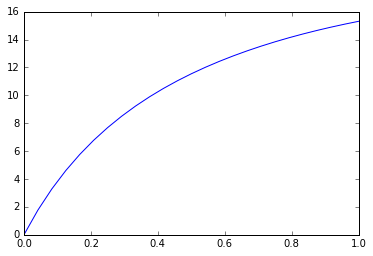

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
gr = np.linspace(0, 1, 25)
plt.plot(gr, [SA_mu.subs(mu, i) for i in gr])

In [42]:
lipid = re.compile('(\d\d\d)(_)(.)')
lipid_demand = {}
for key, value in ijo.reactions.Ec_biomass_iJO1366_WT_53p95M.metabolites.items():
    if lipid.search(key.id):
        lipid_demand[key.id] = abs(value)
        
for met, requirment in lipid_demand.items():
    component_mass = me.metabolites.get_by_id(met).formula_weight / 1000.
    # All these components have the form x1__ wher x is lipid class
    lipid_type = met.split('1')[0]
    SA_id = 'SA_' + lipid_type
    rxn = Reaction('Demand_' + met)
    me.add_reaction(rxn)
    
    SA = 1. if SA_id == 'SA_clpn' else .5
        
    rxn.add_metabolites({met: -1 * requirement, SA_id: SA * mmol * requirement,
                         'component_demand_biomass': component_mass * requirement})
    rxn.lower_bound = 0.
    rxn.upper_bound = 1000.
    
for lipid_SA in ['SA_clpn', 'SA_pg', 'SA_pe']:
    rxn = Reaction(lipid_SA + '_to_SA_lipid')
    me.add_reaction(rxn)
    rxn.add_metabolites({lipid_SA: -1, 'SA_lipid': 1})

In [43]:
lipid_type_demand = defaultdict(float)
for met, value in lipid_demand.items():
    lipid_type = met.split('1')[0]
    lipid_type_demand[lipid_type] += value

In [44]:
mass = me.translation_data.dummy.mass
dummy = me.metabolites.get_by_id('protein_dummy')
SA_inner = dummy.get_surface_area('Inner_Membrane')
SA_outer = dummy.get_surface_area('Outer_Membrane')

dummy_membrane_reactions = {'dummy_protein_to_mass': {'protein_biomass': -mass,
                                                      'protein_dummy': -1,
                                                      'dummy_protein_biomass': mass},
                           'dummy_protein_to_Inner_Membrane': {'protein_biomass': -mass,
                                                               'protein_dummy': -1,
                                                               'dummy_protein_biomass': mass,
                                                               'SA_unmodeled_protein_Inner_Membrane': SA_inner},
                           'dummy_protein_to_Outer_Membrane': {'protein_biomass': -mass,
                                                               'protein_dummy': -1,
                                                               'protein_biomass': mass, # TODO Make dummy again!
                                                               'SA_unmodeled_protein_Outer_Membrane': SA_outer}}
for rxn_id, stoich in dummy_membrane_reactions.items():
    rxn = cobra.Reaction(rxn_id)
    me.add_reaction(rxn)
    rxn.add_metabolites(stoich)

## Add translocation for "functional" dummy protein
# include two most commont translocation pathways for inner and outer membranes
membrane_dict = {'Inner_Membrane': ['srp_translocation'],
                 'Outer_Membrane': ['sec_translocation', 'bam_translocation']}

for membrane, translocation_pathways in membrane_dict.items():
    data = PostTranslationData('Translocate_dummy_%s' % membrane, me, 
                               'protein_dummy_%s' % membrane, 'protein_dummy')
    data.surface_area = {'SA_protein_%s' % membrane: dummy.get_surface_area(membrane)}
    for pathway in translocation_pathways:
        data.translocation[pathway] = 1
    rxn = PostTranslationReaction('Translocate_dummy_%s' % membrane)
    me.add_reaction(rxn)
    rxn.posttranslation_data = data
    rxn.update()

# Complexes are required to perform metabolic functions
data = ComplexData('CPLX_dummy_Inner_Membrane', me)
data.stoichiometry = {'protein_dummy_Inner_Membrane': 1}
data.create_complex_formation()

In [45]:
SA_conversion_dict = {'SA_demand_protein_Inner_Membrane': {'SA_protein_Inner_Membrane': -1,
                                                           'SA_unmodeled_protein_Inner_Membrane': 0,
                                                           'SA_total_protein_Inner_Membrane': 1},
                      
                     'SA_demand_protein_Outer_Membrane': {'SA_protein_Outer_Membrane': -1,
                                                           'SA_unmodeled_protein_Outer_Membrane': 0,
                                                           'SA_total_protein_Outer_Membrane': 1},
                      
                     'SA_demand_dummy_protein_Outer_Membrane': {'SA_unmodeled_protein_Outer_Membrane': -1,
                                                                'SA_total_protein_Outer_Membrane': 1},
                     
                      'SA_demand_dummy_protein_Inner_Membrane': {'SA_unmodeled_protein_Inner_Membrane': -1,
                                                                'SA_total_protein_Inner_Membrane': 1},
                      
                      'SA_demand_lipoprotein_Outer_Membrane': {'SA_lipoprotein': -1,
                                                              'SA_protein_Outer_Membrane': 1},
                      
                     'SA_demand_lipid_Inner_Membrane': {'SA_lipid': -1, 'SA_nonprotein_Inner_Membrane': 1},
                      
                     'SA_demand_lipid_Outer_Membrane': {'SA_lipid': -1, 'SA_nonprotein_Outer_Membrane': 1},
                      
                     'SA_demand_lps_Outer_Membrane': {'SA_lps': -1, 'SA_nonprotein_Outer_Membrane': 1},
                      
                     'SA_components_to_SA_Outer_Membrane': {'SA_total_protein_Outer_Membrane': -.4,
                                                            'SA_nonprotein_Outer_Membrane': -.6,
                                                            'SA_Outer_Membrane': 1},
                     'SA_components_to_SA_Inner_Membrane': {'SA_total_protein_Inner_Membrane': -.157,
                                                            'SA_nonprotein_Inner_Membrane': -.843,
                                                            'SA_Inner_Membrane': 1}
                     }

In [46]:
for rxn_id, stoich in SA_conversion_dict.items():
    for met in stoich:
        if met not in me.metabolites:
            me.add_metabolites([Constraint(met)])
    rxn = Reaction(rxn_id)
    me.add_reaction(rxn)
    rxn.add_metabolites(stoich)

rxn = Reaction('SA_demand_Outer_Membrane')
me.add_reaction(rxn)
rxn.add_metabolites({'SA_Outer_Membrane': -1})
rxn.lower_bound = 0 # 2 * SA_mu
rxn.upper_bound = 1000. #2 * SA_mu

rxn = Reaction('SA_demand_Inner_Membrane')
me.add_reaction(rxn)
rxn.add_metabolites({'SA_Inner_Membrane': -1})
rxn.lower_bound = 2 * SA_mu
rxn.upper_bound = 2 * SA_mu

## Make RNA splicing machinery reactions

In [47]:
ecolime.transcription.add_RNA_splicing(me)

In [48]:
# moved from building (E. coli specific)
# add transcription machinery based on contained RNA types
# info added in buidling however
for transcription_data in me.transcription_data:
    if transcription_data.rho_dependent:
        rho = 'dependent'
    else:
        rho = 'independent'
    if transcription_data.codes_stable_rna:
        stable = 'stable'
    else:
        stable = 'normal'

    transcription_data.subreactions['Transcription_%s_rho_%s' % (stable,
                                                                 rho)] = 1

### Set GAM and NGAM

In [49]:
me.stoichiometric_data.ATPM.lower_bound = 15. #10.33 # NGAM from iML1515

In [50]:
GAM = 5. # Reduced gam from 35 as in iOL
gam_components = {
    "atp_c": -1 * GAM,
    "h2o_c": -1 * GAM,
    "adp_c": 1 * GAM,
    "h_c": 1 * GAM,
    "pi_c": 1 * GAM,}
# There are leftover components from the iJO biomass equation that either 
# 1) have no mechanistic function in the model (glycogen)
# 2) are cofactors that are regenerated (nad)
biomass_components = {
    "glycogen_c": -.023 / (me.metabolites.glycogen_c.formula_weight / 1000.),
    "2ohph_c": -0.000223,
    "nad_c": -.001831,
    "udcpdp_c": -5.5e-05,
    "coa_c": -0.000576,
    "ribflv_c": -0.000223,
    "fad_c": -0.000223,
    "mlthf_c": -0.000223,
    "thf_c": -0.000223,
    "10fthf_c": -0.000223
}


rxn = SummaryVariable('biomass_component_demand')
met = Constraint('component_demand_biomass')
me.add_reaction(rxn)
rxn.add_metabolites(biomass_components)
rxn.add_metabolites(gam_components)
component_mass = sum(me.metabolites.get_by_id(c).formula_weight / 1000. * -v
                     for c, v in biomass_components.items())
rxn.lower_bound = mu
rxn.upper_bound = mu
me.reactions.biomass_component_demand.add_metabolites({met: component_mass})

rxn = SummaryVariable('biomass_component_dilution')
me.add_reaction(rxn)
rxn.add_metabolites({met: -1, me._biomass: 1})

## Attempt to set keffs

In [51]:
keff_list = []
keffs = get_reaction_keffs(me, verbose=True)
for reaction_id, keff in keffs.items():
    keff_list.append(keff)
    me.reactions.get_by_id(reaction_id).keff = keff
    me.reactions.get_by_id(reaction_id).update()

no keff found for keff_GLUTRR_CPLX0_DASH_3741
no keff found for keff_suf_2fe2s_formation_sufBC2DES_pathway_complex
no keff found for keff_suf_4fe4s_formation_sufBC2DES_pathway_complex
no keff found for keff_isc_2fe2s_formation_iscUS_cyaY_pathway_complex
no keff found for keff_isc_4fe4s_formation_iscUS_cyaY_pathway_complex


In [52]:
# Keffs that were not set in the above cell
me.subreaction_data.N_terminal_methionine_cleavage.keff = 1339.4233102860871
me.subreaction_data.peptide_deformylase_processing.keff = 1019.5963333345715
me.reactions.get_by_id('GLUTRR_FWD_CPLX0-3741').keff = 3269.0108007383374
me.subreaction_data.fmet_addition_at_START.keff = 1540.4356849968603
me.subreaction_data.ribosome_recycler.keff = 1059.6910912619182
me.subreaction_data.UAG_PrfA_mono_mediated_termination.keff = 1721.7910609284945
me.subreaction_data.UGA_PrfB_mono_mediated_termination.keff = 1700.2966587695353
me.subreaction_data.UAA_generic_RF_mediated_termination.keff = 1753.4238515034572

In [53]:
# These should be coupled to translation not ribosome formation per iOL1650
Inf_modifications = ['Translation_initiation_factor_InfA', 'Translation_gtp_initiation_factor_InfB',
                    'Translation_initiation_factor_InfC']
for sub in Inf_modifications:
    me.complex_data.ribosome.modifications[sub] = 0
    for data in me.translation_data:
        data.modifications[sub]= -1

## Clean up and update everything

In [54]:
# RNA_dummy, TU_b3247, TU_b3705 do not have RNAP, this is set as the most common RNAP
for data in me.transcription_data:
    if len(data.RNA_polymerase) == 0:
        data.RNA_polymerase = 'RNAP70-CPLX'

## Model updates and corrections

In [55]:
# Add NDH flux split constraint
for rxn in me.metabolites.get_by_id('NADH-DHII-MONOMER_mod_mg2_mod_cu_mod_fad').metabolic_reactions:
    rxn.stoichiometric_data.stoichiometry['ndh2_constraint'] = 1
    rxn.update()
for rxn in me.metabolites.get_by_id('NADH-DHI-CPLX_mod_2fe2s_mod_4fe4s_mod_fmn').metabolic_reactions:
    rxn.stoichiometric_data.stoichiometry['ndh1_constraint'] = 1
    rxn.update()
rxn = cobra.Reaction('ndh_flux_split_constraint')
me.add_reaction(rxn)
rxn.reaction = 'ndh1_constraint + ndh2_constraint ->'

Created <Metabolite ndh2_constraint at 0x7f4f6c418510> in <MetabolicReaction NADH5_FWD_NADH-DHII-MONOMER_mod_mg2_mod_cu_mod_fad at 0x7f4f3b3aca10>
Created <Metabolite ndh1_constraint at 0x7f4f364ee5d0> in <MetabolicReaction NADH17pp_FWD_NADH-DHI-CPLX_mod_2fe2s_mod_4fe4s_mod_fmn at 0x7f4f3b4658d0>


### Include peripheral proteins to the membrane capacity constraint

In [56]:
# These need accounted for as membrane proteins
translocation_dict = {'DLACTDEHYDROGFAD-MONOMER_mod_fad': {'protein_b2133': 'Inner_Membrane'},
                      'EG12069-MONOMER_mod_fad': {'protein_b2210': 'Inner_Membrane'},
                      'NADH-DHII-MONOMER_mod_mg2_mod_cu_mod_fad': {'protein_b1109': 'Inner_Membrane'},
                      'AERGLYC3PDEHYDROG-CPLX_mod_1:fad': {'protein_b3426': 'Inner_Membrane'},
                      'ANGLYC3PDEHYDROG-CPLX_mod_fmn': {'protein_b2241': 'Inner_Membrane',
                                                        'protein_b2242': 'Inner_Membrane',
                                                        'protein_b2243': 'Inner_Membrane'},
                     'CPLX0-3141' : {'protein_b3029': 'Inner_Membrane'},
                     'CPLX0-253_mod_fad': {'protein_b3028': 'Inner_Membrane'},
                     'CPLX0-7458': {'protein_b4467': 'Inner_Membrane'}}
for cplx, protein_loc in translocation_dict.items():
    for protein, location in protein_loc.items():
        protein_location = protein + '_' + location
        thickness = me.global_info['membrane_thickness'][location]
        mass = me.metabolites.get_by_id(protein).mass

        cplx_data = me.complex_data.get_by_id(cplx)
        cplx_data.stoichiometry[protein_location] = cplx_data.stoichiometry.pop(protein)

        data = PostTranslationData('translocation_' + protein,
                                  me, protein_location, protein)
        data.surface_area = {'SA_protein_' + location: (1.21 / thickness * 2.) * mass * mmol}

        rxn = PostTranslationReaction('translocation_' + protein.replace('protein_', ''))
        me.add_reaction(rxn)
        rxn.posttranslation_data = data
        rxn.update()

In [57]:
# Add reaction subsystems from iJO to model
for rxn in ijo.reactions:
    if rxn.id in me.stoichiometric_data:
        data = me.stoichiometric_data.get_by_id(rxn.id)
    else:
        continue
    for r in data.parent_reactions:
        r.subsystem = rxn.subsystem

In [58]:
# TODO confirm whether selenocystine proteins can be made
me.subreaction_data.sec_addition_at_UGA.stoichiometry = {'cys__L_c': -1,
 'generic_tRNA_UGA_cys__L_c': -1,
 'h2o_c': -1,
 'h_c': 1,
 'pi_c': 1}
me.subreaction_data.sec_addition_at_UGA.enzyme = None

In [59]:
# Newly annotated modification gene (w/ high confidence)
mod = me.modification_data.get_by_id('mod_acetyl_c')
mod.enzyme = 'RimL_mono'
mod.stoichiometry = {'accoa_c':-1, 'coa_c':1}

# This reaction does not occur. It prefers NADPH over NADH
# This is important for acetate overflow metabolism with inner membrane sweeps
me.reactions.get_by_id('GLYCLTDx_FWD_CPLX0-235').knock_out()
me.reactions.get_by_id('GLYCLTDx_FWD_G6539-MONOMER').knock_out()

# This reaction does not likely occur at high rates spontaneously
me.reactions.GLYCtpp_FWD_SPONT.knock_out()

# This uses a dummy protein that should take up membrane surface area
me.reactions.QUIN2tpp_FWD_CPLX_dummy.knock_out()
me.reactions.QUIN2tpp_REV_CPLX_dummy.knock_out()

# Correction from iML
me.reactions.MOX_REV_CPLX_dummy.upper_bound = 0
me.reactions.get_by_id('DHPTDNRN_REV_DIHYDROPTERIREDUCT-CPLX_mod_fad').upper_bound = 0
me.reactions.get_by_id('DHPTDNR_REV_DIHYDROPTERIREDUCT-CPLX_mod_fad').upper_bound = 0

# cobalamin is not essential in e. coli and there is no evidence
# of this gene requiring this modification.
me.reactions.EX_cbl1_e.lower_bound = 0
me.complex_data.QueG_mono_mod_adocbl.modifications.pop('mod_adocbl_c')
me.complex_data.QueG_mono_mod_adocbl.formation.update()
print me.reactions.formation_QueG_mono_mod_adocbl.reaction

# Turn off reactions that throw off results as in iOL
KO_list = ['DHPTDNR','DHPTDNRN', 'SUCASPtpp','SUCFUMtpp', 'SUCMALtpp', 'SUCTARTtpp', 
           'CAT', 'FHL', 'SPODM', 'SPODMpp']
for reaction in KO_list:
    data = me.stoichiometric_data.get_by_id(reaction)
    data.lower_bound = 0
    data.upper_bound = 0
    
# this RNAP/sigma factor should not be used to transcribe    
for rxn in me.metabolites.get_by_id('RNAP32-CPLX').reactions:
    if rxn.id != 'formation_RNAP32-CPLX' and rxn.transcription_data.codes_stable_rna:
        rxn.upper_bound = 0
        print rxn
        
me.reactions.NH4tpp_FWD_SPONT.remove_from_model()
me.reactions.NH4tpp_REV_SPONT.remove_from_model()

# I dont think this complex is correct
me.reactions.get_by_id('formation_ATPSYN-CPLX_EG10106-MONOMER').knock_out()

# It's know that the importers for these metabolites are symporters
# but it is not confirmed that these add to the protein gradient when exporting
me.stoichiometric_data.ACt2rpp.stoichiometry.pop('h_c')
me.stoichiometric_data.ACt2rpp.stoichiometry.pop('h_p')
    
me.stoichiometric_data.PYRt2rpp.stoichiometry.pop('h_c')
me.stoichiometric_data.PYRt2rpp.stoichiometry.pop('h_p')

protein_b4166 --> QueG_mono_mod_adocbl


-1.0

In [60]:
# Temporary reaction to prevent creation of protein to fill outer membrane
r = cobra.Reaction('outer_protein_fix')
me.add_reaction(r)
r.reaction = ' -> SA_protein_Outer_Membrane'

In [61]:
me.update()
#with open("full_model_58.pickle", "wb") as outfile:
#    cPickle.dump(me, outfile)
me.prune()

In [62]:
me.reactions.dummy_reaction_FWD_CPLX_dummy.objective_coefficient = 1.
me.reactions.EX_glc__D_e.lower_bound = -1000
me.reactions.EX_o2_e.lower_bound = -1000
# we can now set the unmodeled protein fraction
me.unmodeled_protein_fraction = .4
me.reactions.ATPM_FWD_SPONT.lower_bound =12.

In [63]:
n_genes = len(me.metabolites.query(re.compile('RNA_b[0-9]')))
print("number of genes in the model %d (%.2f%%)" % (n_genes, n_genes * 100. / (1678)))

number of genes in the model 1674 (99.76%)


## Solve

In [64]:
me.reactions.MOX_FWD_CPLX_dummy.knock_out()
me.reactions.MOX_REV_CPLX_dummy.knock_out()
me.reactions.get_by_id('GLYCLTDx_FWD_CPLX0-235').knock_out()
me.reactions.get_by_id('GLYCLTDx_FWD_G6539-MONOMER').knock_out()

In [65]:
with open("prototype_64.pickle", "wb") as outfile:
    cPickle.dump(me, outfile)

In [66]:
# Inner Membrane
me.reactions.SA_components_to_SA_Inner_Membrane.add_metabolites({'SA_total_protein_Inner_Membrane': -.17,
                                                                 'SA_nonprotein_Inner_Membrane': -.83},
                                                                combine=False)


# Unmodeled protein fraction
me.unmodeled_protein_fraction = .4


# Non growth associated maint.
me.reactions.ATPM_FWD_SPONT.lower_bound = 15.


# Update reaction keffs
for r in me.stoichiometric_data.CS.parent_reactions:
    r.keff = 897.
    r.update()
# Compile expressions
#SOPLEX
expressions = compile_expressions(me)

In [71]:
me.unmodeled_protein_fraction = .2

In [72]:
me._protein_biomass_dilution.reaction

'0.25 dummy_protein_biomass + protein_biomass --> 1.25 biomass'

In [67]:
using_soplex=False
if using_soplex:
    binary_search(me, min_mu=.1, max_mu=.3, debug=False, mu_accuracy=1e-2)
else:
    from qminos.me1 import ME_NLP1
    me.reactions.EX_glc__D_e.lower_bound = -1000.
    me.reactions.EX_glc__D_e.upper_bound = 1000.
    # The object containing solveME methods--composite that uses a ME model object 
    # Provide growth_key = 'mu' for minime models,
    me_nlp = ME_NLP1(me, growth_key='mu')
    # Use bisection for now (until the NLP formulation is worked out for the new prototype 44
    muopt, hs, xopt, cache = me_nlp.bisectmu(precision=1e-2, mumax=1.)    
    # Access the solution that is saved in the original minime object
    sol = me.solution
    sol.f
    sol.x_dict

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 69.586847 seconds
Finished substituting S,lb,ub in 3.055474 seconds
Finished makeME_LP in 0.682175 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 5.147127 seconds
Finished makeME_LP in 1.196028 seconds
Getting MINOS parameters from ME_NLP...
2 0.5 0.5 0.75 0.75 1
Finished substituting S,lb,ub in 4.989754 seconds
Finished makeME_LP in 1.296356 seconds
Getting MINOS parameters from ME_NLP...
3 0.5 0.5 0.625 0.625 1
Finished substituting S,lb,ub in 4.873569 seconds
Finished makeME_LP in 1.248209 seconds
Getting MINOS parameters from ME_NLP...
4 0.5625 0.5625 0.625 0.5625 optimal
Finished substituting S,lb,ub in 5.062537 seconds
Finished makeME_LP in 1.229594 seconds
Getting MINOS parameters from ME_NLP...
5 0.5625 0.5625 0.59375 0.59375 1
Finished substituting S,lb,ub in 5.200325 seconds
Finished makeME_LP in 1.194812 seconds
Getting MINOS parameters 

In [73]:
me.reactions.get_by_id('SUCDi_FWD_SUCC-DEHASE_mod_3fe4s_mod_fad_mod_2fe2s_mod_4fe4s').keff

75.44091416255003

In [81]:
#keff = me.reactions.get_by_id('SUCDi_FWD_SUCC-DEHASE_mod_3fe4s_mod_fad_mod_2fe2s_mod_4fe4s').keff
for i in [.25, .1, .01]:
    me.reactions.get_by_id('SUCDi_FWD_SUCC-DEHASE_mod_3fe4s_mod_fad_mod_2fe2s_mod_4fe4s').keff = keff * i
    print keff * i
    me.reactions.get_by_id('SUCDi_FWD_SUCC-DEHASE_mod_3fe4s_mod_fad_mod_2fe2s_mod_4fe4s').update()
    
    me_nlp = ME_NLP1(me, growth_key='mu')
    me_nlp.compiled_expressions = me_nlp.compile_expressions()
    hs= None
    for lb in np.linspace(8.6, 2, 7):
        me.reactions.EX_glc__D_e.lower_bound = -lb
        me.reactions.EX_glc__D_e.upper_bound = 1000
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=1e-2, mumax=1., basis=hs)    
        # Access the solution that is saved in the original minime object
        sol = me.solution
        sol.f
        sol.x_dict
        with open('./sucdi/%.2f_%.2f_gluc_sucdi.pickle' % (i, lb), 'wb') as f:
            cPickle.dump(sol, f)

18.8602285406
iter	muopt    	a     	b     	mu1       	stat1
Finished substituting S,lb,ub in 3.016060 seconds
Finished makeME_LP in 0.663414 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 3.279853 seconds
Finished makeME_LP in 0.675439 seconds
Getting MINOS parameters from ME_NLP...
2 0.5 0.5 0.75 0.75 1
Finished substituting S,lb,ub in 3.271033 seconds
Finished makeME_LP in 0.675294 seconds
Getting MINOS parameters from ME_NLP...
3 0.625 0.625 0.75 0.625 optimal
Finished substituting S,lb,ub in 3.115394 seconds
Finished makeME_LP in 0.678911 seconds
Getting MINOS parameters from ME_NLP...
4 0.625 0.625 0.6875 0.6875 1
Finished substituting S,lb,ub in 3.285509 seconds
Finished makeME_LP in 0.688695 seconds
Getting MINOS parameters from ME_NLP...
5 0.625 0.625 0.65625 0.65625 1
Finished substituting S,lb,ub in 3.117283 seconds
Finished makeME_LP in 0.666576 seconds
Getting MINOS parameters from ME_NLP...
6 0.625 0.625 0.640625 

In [72]:
import escher
view = escher.Builder("iJO1366.Central metabolism")
view.reaction_data = me.get_metabolic_flux()
view.display_in_notebook()

In [ ]:
rxns = ['CS', 'ACONTa', 'ACONTb', 'ICDHyr', 'AKGDH', 'SUCOAS', 'SUCDi', 'FUM', 'MDH', 'MDH3', 'MDH2', 'MOX',
       'MALS', 'ICL']
default_keff_dict = {}


for rxn in rxns:
    for r in me.stoichiometric_data.get_by_id(rxn).parent_reactions:
        default_keff_dict[r.id] = r.keff
for i in [.75, .5, .25, .1, .01]:
    for rxn in rxns:
        for r in me.stoichiometric_data.get_by_id(rxn).parent_reactions:
            r.keff = default_keff_dict[r.id] * i
            r.update()
    
    me_nlp = ME_NLP1(me, growth_key='mu')
    me_nlp.compiled_expressions = me_nlp.compile_expressions()
    hs= None
    for lb in np.linspace(12, 2, 10):
        me.reactions.EX_glc__D_e.lower_bound = -lb
        me.reactions.EX_glc__D_e.upper_bound = 1000
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=1e-2, mumax=1., basis=hs)    
        # Access the solution that is saved in the original cobrame object
        sol = me.solution
        sol.f
        sol.x_dict
        with open('/home/sbrg-cjlloyd/ecolime/prototype_notebooks/tca_no_mem/%.2f_%.2f_gluc_tca.pickle' % (i, lb), 'wb') as f:
            cPickle.dump(sol, f)